# ANALYSE DES SENTIMENTS SUR TWITTER
Ce projet permet d'analyser les sentiments exprimés dans des tweets enutilisantdes techniques de traitement du langage naturel (NLP) et de deep learning.
Adapté pour un dataset Kaggle avec des fichiers d'entraînement et de validation séparés.

## Sommaire
- <a href="#importation">1. Importation des bibliothèques</a>
- <a href="#ressources-nltk">2. Téléchargment des ressources NLTK</a>
- <a href="#charg-explo-donnees">3. Chargement et Exploration des données</a>
- <a href="#pretraitement">4. Prétraitement du texte</a>
- <a href="#visualisation">5. Visualisation des données</a>
- <a href="#tradi-tdidf">6. Approche traditionnelle avec TF-IDF</a>
- <a href="#fonction-principale">Foction Principale</a>

## 1. <a id="importation">Importation des bibliothèques</a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
# import gradio as gr

## 2. <a id="ressources-nltk">Téléchargement des ressources NLTK</a>
L'importation des bibliothèques seules ne suffit pas pour que `nltk` fonctionne correctement. Les ressources comme les stopwords, le tokeniseur et le lemmatiseur ne sont pas incluses par défaut. Elles doivent être téléchargées séparément.



In [10]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/arnaudstadler/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arnaudstadler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arnaudstadler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 3. <a id="charg-explo-donnees">Chargment et Exploration des données</a>

In [11]:
def load_data(train_path, val_path=None):
  # Chargement du dataset d'entraînement
  train_data = pd.read_csv(train_path)
  print(f"Diemnsion du dataset d'entraînement : {train_data.shape}")
  print("Aperçu du dataset d'entraînement : ")
  print(train_data.head())

  # Vérification des colonnes du dataset
  print("\nColonnes du dataset d'entraînement : ")
  print(train_data.columns.tolist())

  # si un fichier de validation
  if val_path:
    val_data = pd.read_csv(val_path)
    print(f"\nDimensions du dataset de validation : {val_data.shape}")
    print(val_data.head())
    return train_data, val_data
  else:
    return train_data, None
  
  train_data = train_data.drop(columns=['topic'])
  
  val_data = val_data.drop(columns=['topic'])
  

## 4. <a id="pretraitement">Prétraitement du texte</a>
Pourquoi le prétraitement est important ?
1. **Réduction du bruit** : Les tweets contiennent souvent beucoup d'éléments non pertinents pour l'analyse des sentiments (URLs, mentions, etc.).
2. **Normalisation** : Les différentes formes d'un même mot (pluriels, conjugaisons) sont ramenées à une forme santard.
3. **Réduction de la dimensionnalité** : En supprimant les stopwords et en utilisant la lemmatisation, on réduit le nombre de mots uniques, ce qui facilite l'apprentissage des modèles.
4. **Amélioration des performances** : Un texte bien prétraité permet aux modèles de se concentrer sur les mots et expressions qui véhiculent réeelement un sentiment.  

In [12]:
def preprocess_text(text):
  # Vérifier si le texte est une chaîne de caractères
  if not isinstance(text, str):
    return ""

  # Convertir en minuscules
  text = text.lower()

  # Supprimer les URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)

  # Supprimer les mentions utilisateurs (@user)
  text = re.sub(r'@\w+', '', text)

  # Supprimer les hashtags
  text = re.sub(r'#\w+', '', text)

  # Supprimer les caractères non-alphanumériques
  text = re.sub(r'[^\w\s]', '', text)

  # Supprimer les chiffres
  text = re.sub(r'\d+', '', text)

  # Tokenisation
  tokens = word_tokenize(text)

  # Supression des stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  # Lemmatisation
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Rejoindre les tokens
  return ' '.join(tokens)


In [13]:
def prepare_dataset(data, text_column, label_column):
    """
    Prépare le dataset en excluant les tweets "Irrelevant" et en appliquant le prétraitement.
    
    Args:
        data (pd.DataFrame): Le DataFrame contenant les données
        text_column (str): Le nom de la colonne contenant le texte des tweets
        label_column (str): Le nom de la colonne contenant les labels de sentiment
        
    Returns:
        pd.DataFrame: Le DataFrame prétraité
    """
    # Vérifier que les colonnes existent
    if text_column not in data.columns:
        raise ValueError(f"La colonne de texte '{text_column}' n'existe pas dans le dataset")
    if label_column not in data.columns:
        raise ValueError(f"La colonne d'étiquette '{label_column}' n'existe pas dans le dataset")

    # Filtrer les tweets "Irrelevant"
    data = data[data[label_column] != 'Irrelevant'].copy()
    print(f"Nombre de tweets après filtrage des 'Irrelevant': {len(data)}")

    # Appliquer le prétraitement au texte
    data['clean_text'] = data[text_column].apply(preprocess_text)

    # Identifier les valeurs uniques dans la colonne des sentiments
    unique_sentiments = data[label_column].unique()
    print(f"Valeurs uniques de sentiment trouvées : {unique_sentiments}")

    # Créer un mapping des sentiments basé sur les valeurs trouvées
    sentiment_map = {}

    # Essayer de détecter automatiquement le format du sentiment
    if set(unique_sentiments).issubset({0, 1}) or set(unique_sentiments).issubset({'0', '1'}):
        # Dataset binaire (positif/négatif)
        sentiment_map = {0: 0, 1: 1, '0': 0, '1': 1}
        print("Format détecté : Binaire (négatif/positif)")
    elif set(unique_sentiments).issubset({-1, 0, 1}) or set(unique_sentiments).issubset({'-1', '0', '1'}):
        # Dataset ternaire avec -1, 0, 1
        sentiment_map = {-1: 0, 0: 2, 1:1, '-1':0, '0':2, '1':1}
        print("Format détecté : Ternaire (-1=négatif, 0=neutre, 1=positif)")
    elif any(isinstance(x, str) and x.lower() in ['positive', 'negative', 'neutral'] for x in unique_sentiments):
        # Dataset avec texte
        sentiment_map = {'Negative': 0, 'Neutral': 2, 'Positive': 1}
        print("Format détecté : Textuel (negative/neutral/positive)")
    else:
        # Format non reconnu, créer un mapping générique
        sentiment_map = {val: idx for idx, val in enumerate(unique_sentiments)}
        print(f"Format non reconnu. Mapping créé : {sentiment_map}")

    # Appliquer le mapping
    data['sentiment_label'] = data[label_column].map(sentiment_map)

    # Vérifier qu'il n'y a pas de NaN dans les labels après le mapping
    if data['sentiment_label'].isna().any():
        print("ATTENTION : Certaines valeurs de sentiment n'ont pas pu être converties !")
        print("Valeurs problématiques : ", data[data['sentiment_label'].isna()][label_column].unique())
        # Remplir les NaN avec une valeur par défaut (par exemple, 0 pour négatif)
        data['sentiment_label'] = data['sentiment_label'].fillna(0)

    return data 

## 5. <a id="visualisation">Visualisation des données</a>

- La partie visualisation des données est conçue pour explorer et comprendre les caractéristiques de dataset avant de passer à la modélisation.
- La fonction `visualize_data()` crée trois visaulisations principales pour analyser la distribution et les caractéristiques des sentiments dans les tweets.

In [14]:
def visualize_data(data, sentiment_column, text_column):
  """Crée des visualisations pour explorer le dataset"""
  # Distribution des sentiments
  plt.figure(figsize=(10, 6))
  sentiment_counts = data[sentiment_column].value_counts()

  #Création du palette de couleurs plus attrayante
  colors = ['#ff9999', '#66b3ff', '#99ff99'][:len(sentiment_counts)]

  # Affichage du graphique
  ax = sentiment_counts.plot(kind='bar', color=colors)
  for i, v in enumerate(sentiment_counts):
    ax.text(i, v + 0.1, str(v), ha='center')

  plt.title('Distribution des Sentiments', fontsize=14)
  plt.xlabel('Sentiment', fontsize=12)
  plt.ylabel('Nombre de Tweets', fontsize=12)
  plt.tight_layout()
  plt.savefig('sentiment_distribution.png')
  print("Graphique de distributiondes sentiments sauvegardé dans 'sentiment_distribution.png")

  # Longueur des tweets par sentiment
  data['text_length'] = data[text_column].astype(str).apply(len)

  plt.figure(figsize=(12, 7))

  # Utilisation de box plot avec swarmplot pour une meilleure visualisation
  sample_size = int(len(data) * 0.05)
  random_sample = data.sample(n=sample_size, random_state=42)
  ax = sns.boxplot(x=sentiment_column, y='text_length', data=data, palette='Set2')
  sns.swarmplot(x=sentiment_column, y='text_length', data=data, color='0.25', size=1, alpha=0.5)

  plt.title('Longueur des Tweets par Sentiment', fontsize=14)
  plt.xlabel('Sentiment', fontsize=12)
  plt.ylabel('Longueur du Tweet (caractères)', fontsize=12)
  plt.tight_layout()
  plt.savefig('tweet_length_by_sentiment.png')
  print("Graphique de longueur des tweets sauvegardé dans 'tweet_by_length_sentiment.png'")

  # Analyse des mots les plus fréquents par sentiment
  from collections import Counter
  import matplotlib.cm as cm

  # Créer un DataFrame pour les mots les plus fréquents par sentiment
  plt.figure(figsize=(15, 12))

  # Définir le nombre de sentiments dans le dataset
  num_sentiments = data['sentiment_label'].nunique()

  # Ajuster le nombre de sous-graphique en fonction du nombre de sentiment
  fig, axes = plt.subplots(1, num_sentiments, figsize=(15, 6))
  if num_sentiments == 1:
    axes = [axes]     # Assure que axes est toujours une liste

  sentiment_names = {0: 'Négatif', 1: 'Positif', 2: 'Neutre'}

  # Pour chaque sentiment, trouver les mots les plus fréquents
  for i, sentiment_value in enumerate(sorted(data['sentiment_label'].unique())):
    # Filtrer les tweets par sentiment
    sentiment_data = data[data['sentiment_label'] == sentiment_value]

    # Joindre tous les textes nettoyés
    all_words = ' '.join(sentiment_data['clean_text'].astype(str)).split()

    # Compter les mots
    word_counts = Counter(all_words)

    # Prendre les 15 mots les plus fréquents
    most_common = word_counts.most_common(15)

    # Créer des listes pour les graphiques
    words = [word for word, count in most_common]
    counts = [count for word, count in most_common]

    # Tracer le graphique à barre horizontales
    sentiment_name = sentiment_names.get(sentiment_value, f"Sentiment {sentiment_value}")
    axes[i].barh(words, counts, color=cm.Set3(i / num_sentiments))
    axes[i].set_title(f'Mots fréquent - {sentiment_name}')
    axes[i].set_xlabel('Fréquence')

  plt.tight_layout()
  plt.savefig('frequent_words_by_sentiment.png')
  print("Graphique des mots fréquents sauvegardé dans 'frequent_words_by_sentiment.png'")

  return

Ces visulisations constituent une étape d'analyse exploratoire des données (EDA) importante qui aide à :
- Comprendre le déséquilibre éventuel des classes.
- Voir si la longueur des tweets est corrélée au sentiment.
- Identifier les mots caractéristiques de chaque sentiment.

## 6. <a id="tradi-tdidf">Approche Traditionnelle avec TF-IDF</a>

Cette section implémente une méthode classqieu d'analyse de sentiments basé sur des techniques de NLP plus traditionnelles, avant l'ère des transformers.

In [15]:
def train_tfidf_model(train_data, val_data=None):
  # Si pas de données de validation, utiliser une partie des données d'entraînement
  if val_data is None:
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['clean_text'], train_data['sentiment_label'],
        test_size=0.2, random_state=42
    )
  else:
    X_train = train_data['clean_text']
    y_train = train_data['sentiment_label']
    X_val = val_data['clean_text']
    y_val = val_data['sentiment_label']

  print(f"Taille des données d'entraînement : {len(X_train)}")
  print(f"Taille des données de validation : {len(X_val)}")

  # Vectorisation TF-IDF
  print("Vectorisation TF-IDF des données ...")
  tfidf_vectorizer = TfidfVectorizer(max_features=5000)
  X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
  X_val_tdidf = tfidf_vectorizer.transform(X_val)

  # Entraînement du modèle (Régression Logistique)
  print("Entraînement du modèle de régression logistiques ...")
  lr_model = LogisticRegression(max_iter=1000, verbose=1, n_jobs=1, C=0.1, penalty='l2')
  lr_model.fit(X_train_tfidf, y_train)

  # Évaluation du modèle
  y_pred = lr_model.predict(X_val_tdidf)
  accuracy = accuracy_score(y_val, y_pred)
  print(f"Précision du modèle TF-IDF + Régression Logistique : {accuracy:.4f}")

  # Rapport de classification détaillé
  print("\nRapport de classification:")
  print(classification_report(y_val, y_pred))

  # Matrice de confusion
  cm = confusion_matrix(y_val, y_pred)
  plt.figure(figsize=(10, 8))

  # Utiliser un heatmap plus informatif
  sns.heatmap(
      cm,
      annot=True,
      fmt='d',
      cmap='Blues',
      xticklabels=['Négatif', 'Positif', 'Neutre'][:lr_model.classes_.size],
      yticklabels=['Négatif', 'Positif', 'Neutre'][:lr_model.classes_.size]
  )
  plt.title('Matrice de confusion - Modèle TF-IDF', fontsize=14)
  plt.xlabel('Prédiction', fontsize=12)
  plt.ylabel('Réalité', fontsize=12)
  plt.tight_layout()
  plt.savefig('confusion_matrix_tfidf.png')
  print("Matrice de confusion suavegardée dans 'confusion_matrix_tfidf.png'")

  # Analye des caractéristiques les plus importantes
  if hasattr(lr_model, 'coef_'):
    for i, class_label in enumerate(lr_model.classes_):
      # Obtenir les coefficients pour cette classe
      coefficients = lr_model.coef_[i]

      # Obtenir les noms des caractéristiques
      feature_names = tfidf_vectorizer.get_feature_names_out()

      # Créer un DataFrame pour faciliter le tri
      coefficients_df = pd.DataFrame({
          'feature': feature_names,
          'coefficient': coefficients
      })

      # Trier par coefficient absolu décroissant
      sorted_coefficients = coefficients_df.reindex(
          coefficients_df['coefficient'].abs().sort_values(ascending=False).index
      )

      # Afficher les 10 caractéristiques les plus importantes pour cette classe
      sentiment_name = ['Négatif', 'Positif', 'Neutre'][i] if i < 3 else f"Classe {i}"
      print(f"\n10 mots les plus importants pour la classe {sentiment_name} : ")
      print(sorted_coefficients.head(10))

  return lr_model, tfidf_vectorizer

## <a id="fonction-principale">Fonction Principale</a>

=== Analyse des sentiments sur TWITTER ===
Début du traitement...

Chargement des données...
Diemnsion du dataset d'entraînement : (74682, 4)
Aperçu du dataset d'entraînement : 
     id        topic sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

Colonnes du dataset d'entraînement : 
['id', 'topic', 'sentiment', 'text']

Dimensions du dataset de validation : (1000, 4)
     id      topic   sentiment  \
0  3364   Facebook  Irrelevant   
1   352     Amazon     Neutral   
2  8312  Microsoft    Negative   
3  4371      CS-GO    Nega

/var/folders/t9/tb190swx3cdg6kfpytfcpwxr0000gn/T/ipykernel_7156/3967386198.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=sentiment_column, y='text_length', data=data, palette='Set2')
/Users/arnaudstadler/Documents/PROJETS/Twitter_sentiments_analysis/myvenv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 40.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arnaudstadler/Documents/PROJETS/Twitter_sentiments_analysis/myvenv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 27.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arnaudstadler/Documents/PROJETS/Twitter_sentiments_analysis/myvenv/lib/python

Graphique de longueur des tweets sauvegardé dans 'tweet_by_length_sentiment.png'
Graphique des mots fréquents sauvegardé dans 'frequent_words_by_sentiment.png'

=== APPROCHE TRADITIONNELLE ===
Taille des données d'entraînement : 61692
Taille des données de validation : 828
Vectorisation TF-IDF des données ...
Entraînement du modèle de régression logistiques ...
Précision du modèle TF-IDF + Régression Logistique : 0.7633

Rapport de classification:
              precision    recall  f1-score   support

           0       0.71      0.83      0.76       266
           1       0.78      0.85      0.81       277
           2       0.82      0.62      0.71       285

    accuracy                           0.76       828
   macro avg       0.77      0.77      0.76       828
weighted avg       0.77      0.76      0.76       828

Matrice de confusion suavegardée dans 'confusion_matrix_tfidf.png'

10 mots les plus importants pour la classe Négatif : 
     feature  coefficient
1698     fix     3.

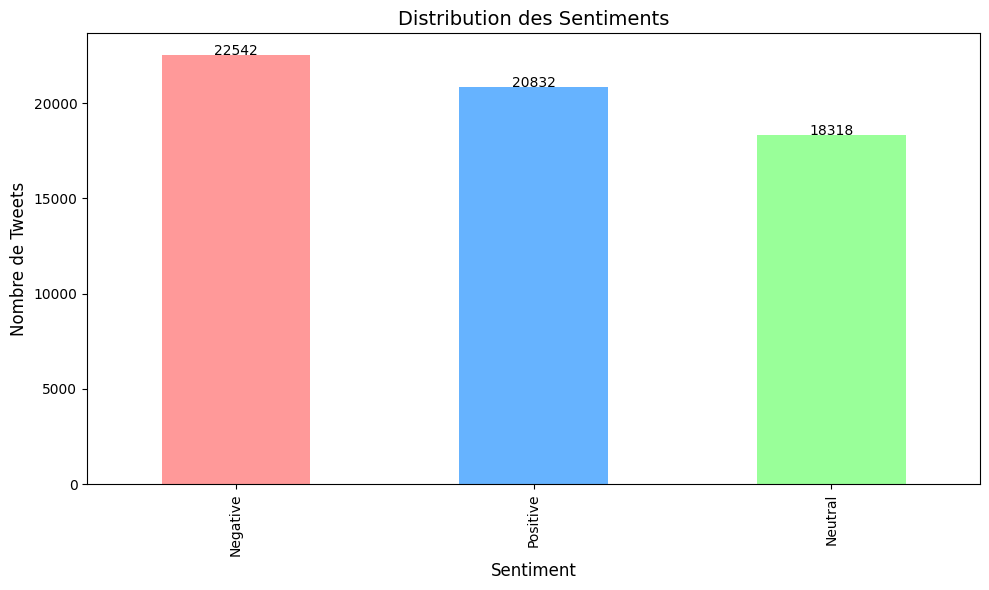

/Users/arnaudstadler/Documents/PROJETS/Twitter_sentiments_analysis/myvenv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 32.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arnaudstadler/Documents/PROJETS/Twitter_sentiments_analysis/myvenv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arnaudstadler/Documents/PROJETS/Twitter_sentiments_analysis/myvenv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


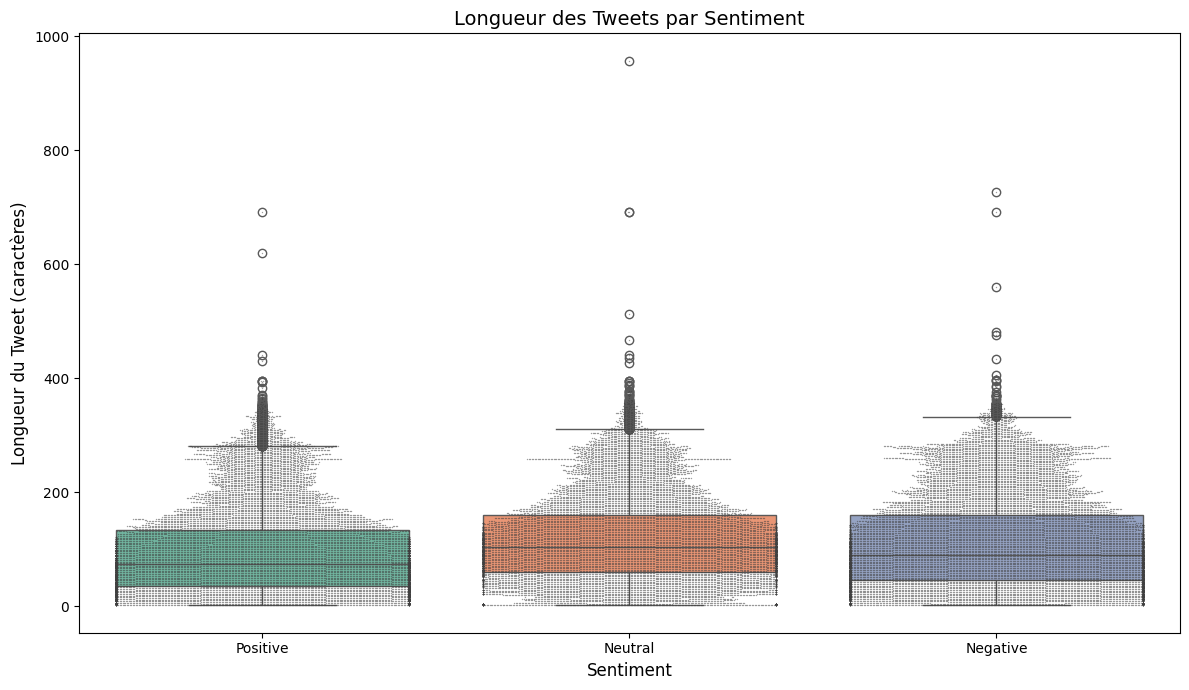

<Figure size 1500x1200 with 0 Axes>

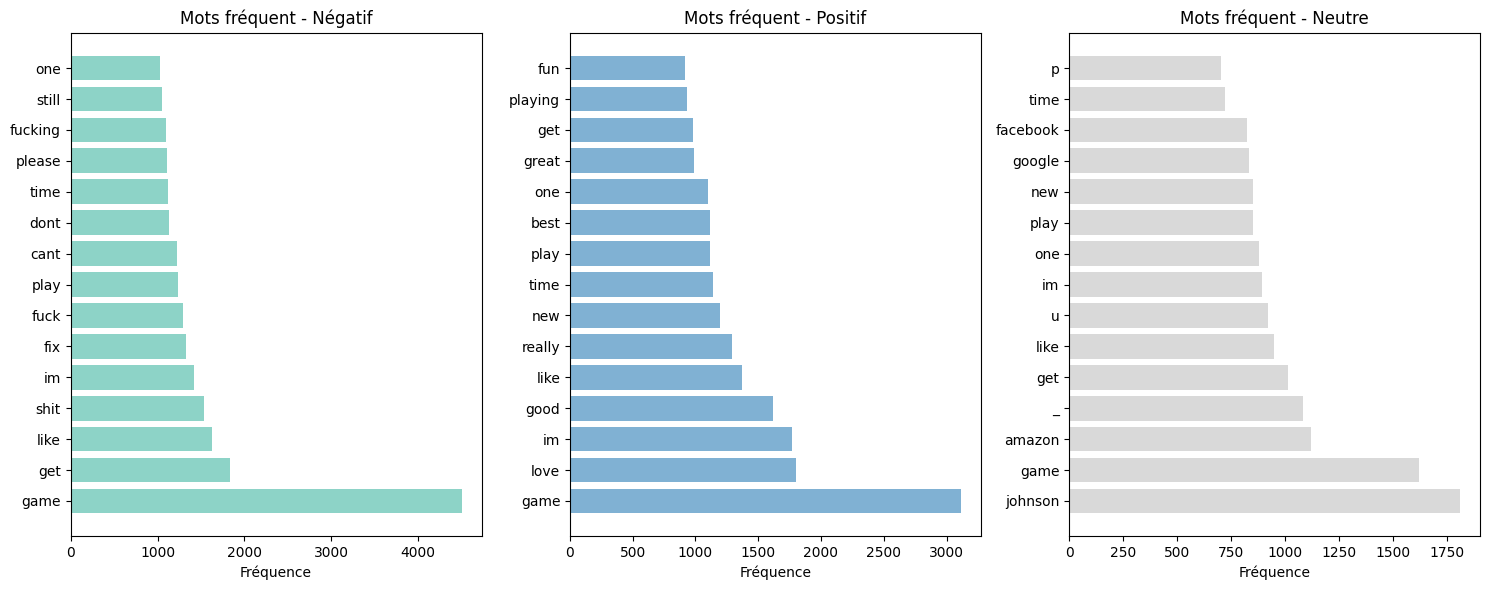

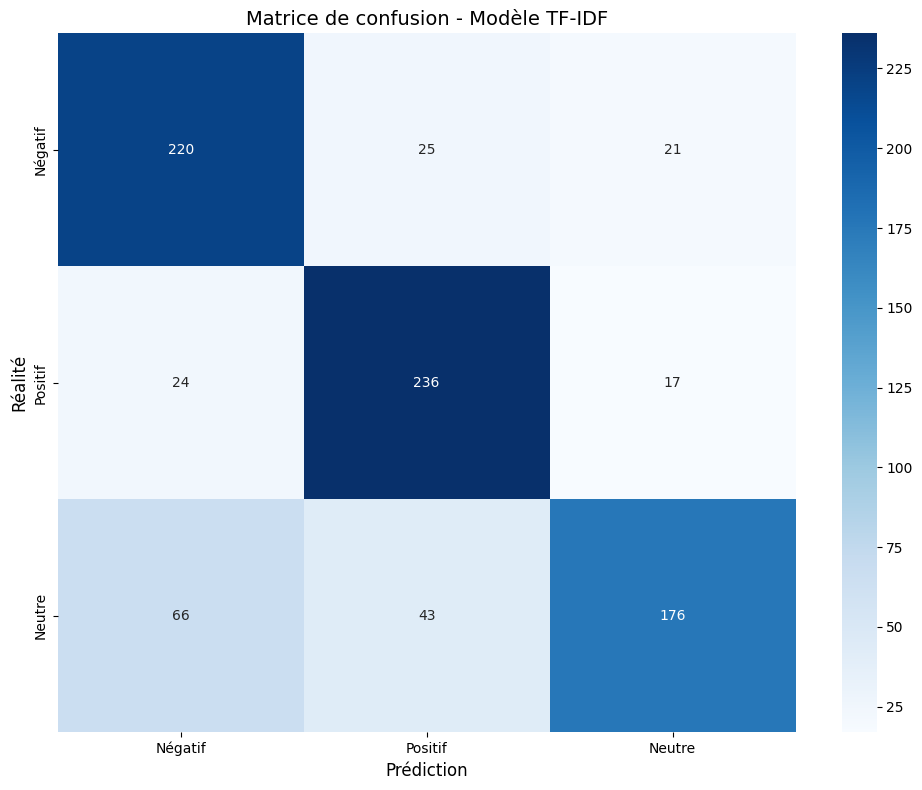

In [16]:
def main():
  print("=== Analyse des sentiments sur TWITTER ===")
  print("Début du traitement...\n")

  # Chemins vers les datasets
  train_path = "/Users/arnaudstadler/Documents/PROJETS/Twitter_sentiments_analysis/data/twitter_training.csv"
  val_path = "/Users/arnaudstadler/Documents/PROJETS/Twitter_sentiments_analysis/data/twitter_validation.csv"

  # Noms des colonnes
  text_column = "text"
  label_column = "sentiment"

  # Chargement des données
  print("Chargement des données...")
  train_data, val_data = load_data(train_path, val_path)

  # Prétraitement
  print("\nPrétraitement des données...")
  processed_train = prepare_dataset(train_data, text_column, label_column)

  if val_data is not None:
    processed_val = prepare_dataset(val_data, text_column, label_column)
  else:
    processed_val = None

  # Visualisation
  print("\nCréation des visualisation...")
  visualize_data(processed_train, label_column, text_column)

  print("\n=== APPROCHE TRADITIONNELLE ===")
  lr_model, tfidf_vectorizer = train_tfidf_model(processed_train, processed_val)

  print("\n===TRAITEMENT TERMINÉ ===")

if __name__ == "__main__":
  main()